In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('preprocessed_water_quality.csv')

#### Declaring GDI formula

In [2]:
# Function to compute Generalized Dunn Index
def generalized_dunn_index(X, labels):
    from scipy.spatial.distance import cdist
    unique_clusters = np.unique(labels[labels != -1])  # Ignore noise (-1)
    if len(unique_clusters) < 2:
        return 0  # Cannot compute GDI for 1 cluster
    centroids = np.array([X[labels == k].mean(axis=0) for k in unique_clusters])
    intra_dists = [cdist(X[labels == k], [centroids[i]]).max() for i, k in enumerate(unique_clusters)]
    inter_dists = cdist(centroids, centroids)
    np.fill_diagonal(inter_dists, np.inf)
    return np.min(inter_dists) / np.max(intra_dists)

##### PCA plotting

In [3]:
import plotly.express as px
from sklearn.decomposition import PCA
import pandas as pd

def plot_clusters_3d(X, labels, title="Interactive 3D Cluster Plot"):
    """
    Plots 3D interactive cluster visualization using PCA and Plotly.

    Parameters:
        X (array-like): Preprocessed feature set (n_samples x n_features)
        labels (array-like): Cluster labels (n_samples,)
        title (str): Plot title
    """
    # Reduce to 3 components for 3D plotting
    X_3d = PCA(n_components=3).fit_transform(X)

    # Convert to DataFrame for Plotly
    df_plot = pd.DataFrame(X_3d, columns=["PC1", "PC2", "PC3"])
    df_plot["Cluster"] = labels.astype(str)  # Convert to string for better legend handling

    fig = px.scatter_3d(
        df_plot, x="PC1", y="PC2", z="PC3",
        color="Cluster",
        title=title,
        opacity=0.75,
        color_discrete_sequence=px.colors.qualitative.Set1
    )
    fig.update_layout(
        scene=dict(
            xaxis_title="PCA 1",
            yaxis_title="PCA 2",
            zaxis_title="PCA 3"
        ),
        legend_title_text='Cluster'
    )
    fig.show()

# BIRCH Clustering with Hyperparameter Tuning

In [4]:
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

X = df  

#Hyperparameter grid
thresholds = [0.5, 1.0, 1.5]
branching_factors = [25, 50]
cluster_options = [2, 3, 4, 5]

best_score = -1
best_params = {}
best_labels = None
best_metrics = {}

print("Performing BIRCH hyperparameter tuning...\n")

# Grid search
for t in thresholds:
    for b in branching_factors:
        for k in cluster_options:
            model = Birch(threshold=t, branching_factor=b, n_clusters=k)
            labels = model.fit_predict(X)

            print(f"Trying: threshold={t}, branching_factor={b}, n_clusters={k}, clusters={set(labels)}")

            if len(set(labels)) < 2:
                continue

            try:
                sil = silhouette_score(X, labels)
                dbi = davies_bouldin_score(X, labels)
                gdi = generalized_dunn_index(X, labels)
                score = sil  # Optimize based on silhouette
            except Exception as e:
                print(f"Error calculating metrics: {e}")
                continue

            if score > best_score:
                best_score = score
                best_params = {'threshold': t, 'branching_factor': b, 'n_clusters': k}
                best_labels = labels
                best_metrics = {'Silhouette': sil, 'DBI': dbi, 'GDI': gdi}

# Output
if best_metrics:
    print("\n✅ Best Parameters Found:")
    for key, val in best_params.items():
        print(f"  {key}: {val}")

    print("\n📊 Evaluation Metrics:")
    print(f"Silhouette Score: {best_metrics['Silhouette']:.3f}")
    print(f"Davies-Bouldin Index: {best_metrics['DBI']:.3f}")
    print(f"Generalized Dunn Index: {best_metrics['GDI']:.3f}")

    print("\n📌 Cluster Distribution:")
    print(pd.Series(best_labels).value_counts().sort_index())

else:
    print("❌ No valid clustering configuration found. Check data or expand parameter range.")

Performing BIRCH hyperparameter tuning...

Trying: threshold=0.5, branching_factor=25, n_clusters=2, clusters={0, 1}
Trying: threshold=0.5, branching_factor=25, n_clusters=3, clusters={0, 1, 2}
Trying: threshold=0.5, branching_factor=25, n_clusters=4, clusters={0, 1, 2, 3}
Trying: threshold=0.5, branching_factor=25, n_clusters=5, clusters={0, 1, 2, 3, 4}
Trying: threshold=0.5, branching_factor=50, n_clusters=2, clusters={0, 1}
Trying: threshold=0.5, branching_factor=50, n_clusters=3, clusters={0, 1, 2}
Trying: threshold=0.5, branching_factor=50, n_clusters=4, clusters={0, 1, 2, 3}
Trying: threshold=0.5, branching_factor=50, n_clusters=5, clusters={0, 1, 2, 3, 4}
Trying: threshold=1.0, branching_factor=25, n_clusters=2, clusters={0, 1}
Trying: threshold=1.0, branching_factor=25, n_clusters=3, clusters={0, 1, 2}
Trying: threshold=1.0, branching_factor=25, n_clusters=4, clusters={0, 1, 2, 3}
Trying: threshold=1.0, branching_factor=25, n_clusters=5, clusters={0, 1, 2, 3, 4}
Trying: thresho

In [5]:
plot_clusters_3d(df, best_labels, title="BIRCH Clustering with best parameters (Interactive 3D View)")

# Bootstrapping

In [ ]:
import numpy as np
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.stats import norm
import random



# Bootstrapping parameters
n_iterations = 100
sample_size = len(X_pca)

silhouette_scores = []
dbi_scores = []
gdi_scores = []

for i in range(n_iterations):
    # Sample with replacement
    indices = np.random.choice(sample_size, size=sample_size, replace=True)
    X_boot = X_pca[indices]

    # Apply OPTICS
    model = OPTICS(min_samples=10, xi=0.05)
    model.fit(X_boot)
    labels = model.labels_

    # Ignore iterations where only 1 cluster (or all noise)
    if len(set(labels)) <= 1 or len(set(labels)) == 1 and -1 in set(labels):
        continue

    # Compute metrics
    sil = silhouette_score(X_boot[labels != -1], labels[labels != -1])
    dbi = davies_bouldin_score(X_boot[labels != -1], labels[labels != -1])
    gdi = generalized_dunn_index(X_boot, labels)

    silhouette_scores.append(sil)
    dbi_scores.append(dbi)
    gdi_scores.append(gdi)

# Function to calculate 95% CI
def calc_ci(data, confidence=0.95):
    mean = np.mean(data)
    std_dev = np.std(data)
    margin = norm.ppf(1 - (1 - confidence)/2) * (std_dev / np.sqrt(len(data)))
    return mean, std_dev, (mean - margin, mean + margin)

# Compute metrics summary
sil_mean, sil_std, sil_ci = calc_ci(silhouette_scores)
dbi_mean, dbi_std, dbi_ci = calc_ci(dbi_scores)
gdi_mean, gdi_std, gdi_ci = calc_ci(gdi_scores)

# Display Results
print("Bootstrapped Evaluation for OPTICS (n=100)\n")
print(f"Silhouette Score: Mean = {sil_mean:.3f}, Std = {sil_std:.3f}, 95% CI = [{sil_ci[0]:.3f}, {sil_ci[1]:.3f}]")
print(f"Davies-Bouldin Index: Mean = {dbi_mean:.3f}, Std = {dbi_std:.3f}, 95% CI = [{dbi_ci[0]:.3f}, {dbi_ci[1]:.3f}]")
print(f"Generalized Dunn Index: Mean = {gdi_mean:.3f}, Std = {gdi_std:.3f}, 95% CI = [{gdi_ci[0]:.3f}, {gdi_ci[1]:.3f}]")

# Fuzzy C-Means


Clustering Metrics:
Silhouette Score: 0.560
Calinski-Harabasz Index: 170336.920
Davies-Bouldin Index: 0.500

Number of clusters: 5

Cluster distribution:
0    5845
1    5845
2    5458
3    5458
4    5896
Name: count, dtype: int64


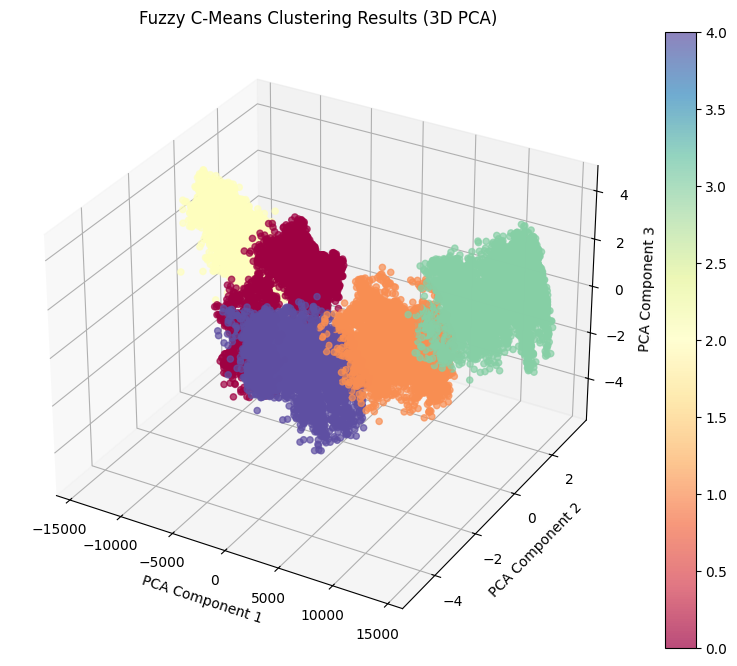

In [6]:
from fcmeans import FCM
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- PCA Dimensionality Reduction to 3 Components ---
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df)

# --- Fuzzy C-Means Clustering ---
n_clusters = 5
fcm = FCM(n_clusters=n_clusters, random_state=42)
fcm.fit(df.values)

# Predict cluster labels
clusters = fcm.predict(df.values)
df['Cluster'] = clusters

# --- Evaluation Metrics (Optional: Fuzzy labels can cause small inconsistency) ---
if len(np.unique(clusters)) > 1:
    silhouette = silhouette_score(df.drop('Cluster', axis=1), clusters)
    calinski = calinski_harabasz_score(df.drop('Cluster', axis=1), clusters)
    davies = davies_bouldin_score(df.drop('Cluster', axis=1), clusters)
    print("\nClustering Metrics:")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Calinski-Harabasz Index: {calinski:.3f}")
    print(f"Davies-Bouldin Index: {davies:.3f}")

# --- Cluster Info ---
print(f"\nNumber of clusters: {n_clusters}")
print("\nCluster distribution:")
print(pd.Series(clusters).value_counts().sort_index())

# --- 3D Visualization ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2],
                     c=clusters, cmap='Spectral', alpha=0.7)

ax.set_title('Fuzzy C-Means Clustering Results (3D PCA)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.colorbar(scatter)
plt.show()

# GMM


Clustering Metrics:
Silhouette Score: 0.560
Calinski-Harabasz Index: 170336.920
Davies-Bouldin Index: 0.500

Number of clusters: 5

Cluster distribution:
0    5896
1    5458
2    5458
3    5845
4    5845
Name: count, dtype: int64


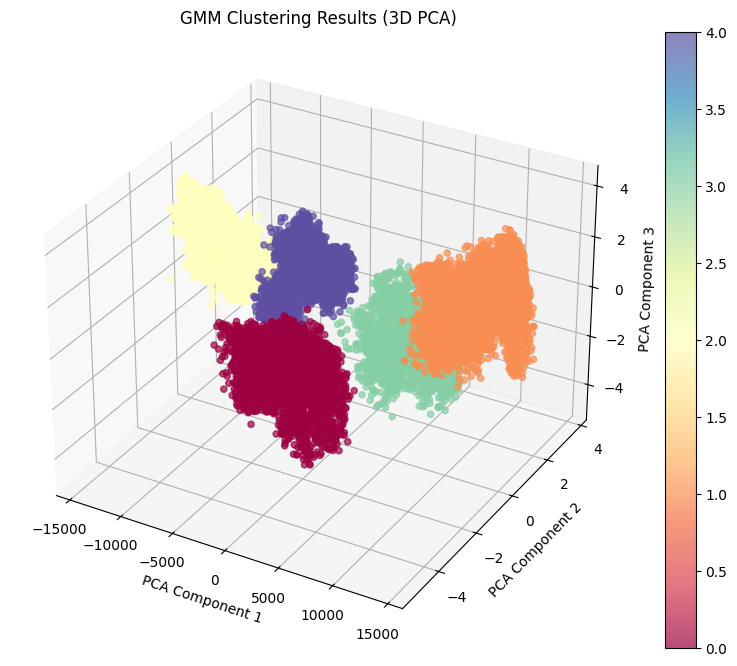

In [7]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- PCA Dimensionality Reduction to 3 Components ---
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df)

# --- GMM Clustering ---
n_clusters = 5
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
gmm.fit(df.values)

# Predict cluster labels
clusters = gmm.predict(df.values)
df['Cluster'] = clusters

# --- Evaluation Metrics ---
if len(np.unique(clusters)) > 1:
    silhouette = silhouette_score(df.drop('Cluster', axis=1), clusters)
    calinski = calinski_harabasz_score(df.drop('Cluster', axis=1), clusters)
    davies = davies_bouldin_score(df.drop('Cluster', axis=1), clusters)
    print("\nClustering Metrics:")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Calinski-Harabasz Index: {calinski:.3f}")
    print(f"Davies-Bouldin Index: {davies:.3f}")

# --- Cluster Info ---
print(f"\nNumber of clusters: {n_clusters}")
print("\nCluster distribution:")
print(pd.Series(clusters).value_counts().sort_index())

# --- 3D Visualization ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2],
                     c=clusters, cmap='Spectral', alpha=0.7)

ax.set_title('GMM Clustering Results (3D PCA)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.colorbar(scatter)
plt.show()

# K-Meioids


Clustering Metrics (K-Medoids):
Silhouette Score: 0.268
Calinski-Harabasz Index: 9109.605
Davies-Bouldin Index: 1.624

Number of clusters: 5

Cluster distribution:
0    10845
1     4308
2     4223
3     5457
4     3669
Name: count, dtype: int64


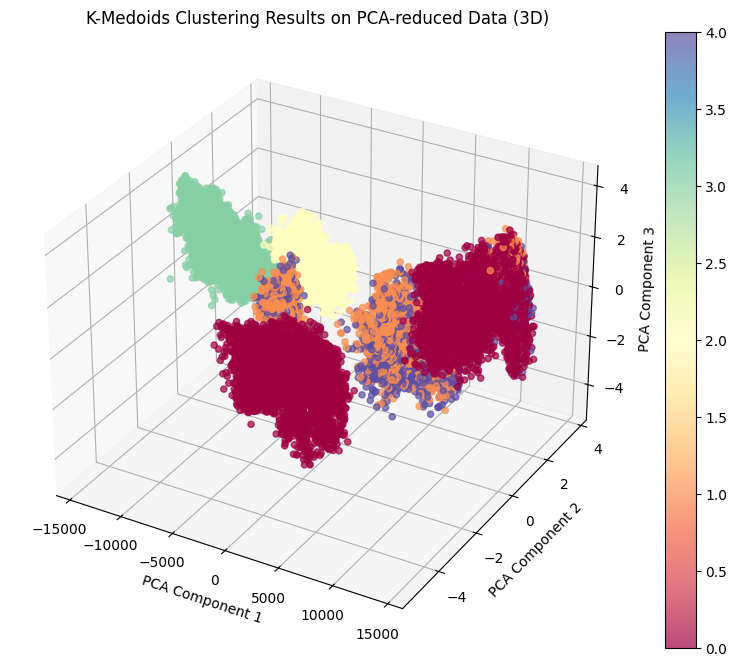

In [8]:
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ==============================
# Step 1: Apply PCA for Visualization
# ==============================
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df)

# ==============================
# Step 2: Normalize Data
# ==============================
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# ==============================
# Step 3: Apply K-Medoids Clustering
# ==============================
n_clusters = 5  # Adjust the number of clusters as needed

kmedoids = KMedoids(n_clusters=n_clusters, metric="euclidean", random_state=42)
clusters = kmedoids.fit_predict(df_scaled)

df['Cluster'] = clusters  # Store the cluster labels in the DataFrame

# ==============================
# Step 4: Evaluate Clustering
# ==============================
silhouette = silhouette_score(df_scaled, clusters)
calinski = calinski_harabasz_score(df_scaled, clusters)
davies = davies_bouldin_score(df_scaled, clusters)

print("\nClustering Metrics (K-Medoids):")
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Calinski-Harabasz Index: {calinski:.3f}")
print(f"Davies-Bouldin Index: {davies:.3f}")

print(f"\nNumber of clusters: {len(set(clusters))}")
print("\nCluster distribution:")
print(pd.Series(clusters).value_counts().sort_index())

# ==============================
# Step 5: 3D Visualization
# ==============================
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2], 
                     c=clusters, cmap='Spectral', alpha=0.7)

ax.set_title('K-Medoids Clustering Results on PCA-reduced Data (3D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.colorbar(scatter)
plt.show()


# OPTICS


Clustering Metrics (excluding noise points):
Silhouette Score: 0.813
Calinski-Harabasz Index: 113896.928
Davies-Bouldin Index: 0.236

Number of clusters found: 2
Number of noise points: 14460

Cluster distribution:
-1    14460
 0     9667
 1     4375
Name: count, dtype: int64


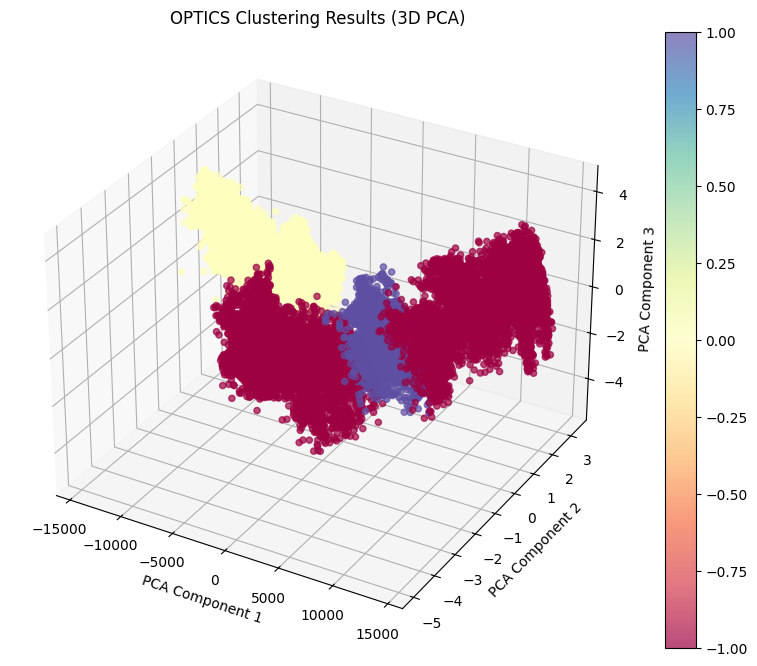

In [13]:
from sklearn.cluster import OPTICS
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- PCA Dimensionality Reduction to 3 Components ---
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df)

# --- OPTICS Clustering ---
optics = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.1) 
clusters = optics.fit_predict(df)

# --- Add cluster labels ---
df['Cluster'] = clusters

# --- Calculate Clustering Metrics (excluding noise points) ---
mask = clusters != -1
if len(np.unique(clusters[mask])) > 1:
    silhouette = silhouette_score(df.drop('Cluster', axis=1)[mask], clusters[mask])
    calinski = calinski_harabasz_score(df.drop('Cluster', axis=1)[mask], clusters[mask])
    davies = davies_bouldin_score(df.drop('Cluster', axis=1)[mask], clusters[mask])
    print("\nClustering Metrics (excluding noise points):")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Calinski-Harabasz Index: {calinski:.3f}")
    print(f"Davies-Bouldin Index: {davies:.3f}")

# --- Basic Cluster Information ---
print(f"\nNumber of clusters found: {len(set(clusters)) - (1 if -1 in clusters else 0)}")
print(f"Number of noise points: {list(clusters).count(-1)}")
print("\nCluster distribution:")
print(pd.Series(clusters).value_counts().sort_index())

# --- 3D Visualization ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2],
                     c=clusters, cmap='Spectral', alpha=0.7)

ax.set_title('OPTICS Clustering Results (3D PCA)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.colorbar(scatter)
plt.show()


## Hyperparameter Tuning

In [10]:
from sklearn.cluster import OPTICS
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd
import numpy as np

# --- Hyperparameter Tuning for OPTICS ---
best_score = -1
best_params = {}
best_clusters = None

param_grid = {
    "min_samples": [5, 10, 20],
    "xi": [0.01, 0.05, 0.1],
    "min_cluster_size": [0.05, 0.1, 0.2]
}

for min_samples in param_grid["min_samples"]:
    for xi in param_grid["xi"]:
        for min_cluster_size in param_grid["min_cluster_size"]:
            optics = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size)
            clusters = optics.fit_predict(df)
            
            # Exclude noise points
            mask = clusters != -1
            if len(np.unique(clusters[mask])) > 1:
                silhouette = silhouette_score(df[mask], clusters[mask])
                calinski = calinski_harabasz_score(df[mask], clusters[mask])
                davies = davies_bouldin_score(df[mask], clusters[mask])
                
                score = silhouette  # Prioritizing silhouette score for best clustering
                if score > best_score:
                    best_score = score
                    best_params = {"min_samples": min_samples, "xi": xi, "min_cluster_size": min_cluster_size}
                    best_clusters = clusters

# --- Apply Best OPTICS Model ---
optics = OPTICS(**best_params)
clusters = optics.fit_predict(df)
df['Cluster'] = clusters

# --- Print Best Parameters ---
print("\nBest Parameters:")
print(best_params)

# --- Calculate Clustering Metrics (excluding noise points) ---
mask = clusters != -1
if len(np.unique(clusters[mask])) > 1:
    silhouette = silhouette_score(df[mask], clusters[mask])
    calinski = calinski_harabasz_score(df[mask], clusters[mask])
    davies = davies_bouldin_score(df[mask], clusters[mask])
    print("\nBest Clustering Metrics (excluding noise points):")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Calinski-Harabasz Index: {calinski:.3f}")
    print(f"Davies-Bouldin Index: {davies:.3f}")

# --- Basic Cluster Information ---
print(f"\nNumber of clusters found: {len(set(clusters)) - (1 if -1 in clusters else 0)}")
print(f"Number of noise points: {list(clusters).count(-1)}")
print("\nCluster distribution:")
print(pd.Series(clusters).value_counts().sort_index())



Best Parameters:
{'min_samples': 10, 'xi': 0.05, 'min_cluster_size': 0.05}

Best Clustering Metrics (excluding noise points):
Silhouette Score: 0.813
Calinski-Harabasz Index: 113896.929
Davies-Bouldin Index: 0.236

Number of clusters found: 2
Number of noise points: 14460

Cluster distribution:
-1    14460
 0     9667
 1     4375
Name: count, dtype: int64


# SOM

Training SOM...
SOM training complete.

Clustering Metrics (SOM):
Silhouette Score: -0.154
Calinski-Harabasz Index: 406.813
Davies-Bouldin Index: 3.359

Number of clusters: 47

Cluster distribution:
0     5072
1      192
2      578
3     3064
4      497
5      646
6      377
7      651
8      117
9      949
11     150
12      22
13      71
14     202
15     109
16     101
17     322
18     221
19    5011
21     391
22      10
23     611
24    1027
25      26
26      65
27     599
28      54
29     706
32     634
33     135
34     169
35     661
36      25
37     681
38     117
42     257
43     103
44     250
45     206
46     244
47     131
48      27
51      45
54    2479
55      83
56      69
84     345
Name: count, dtype: int64


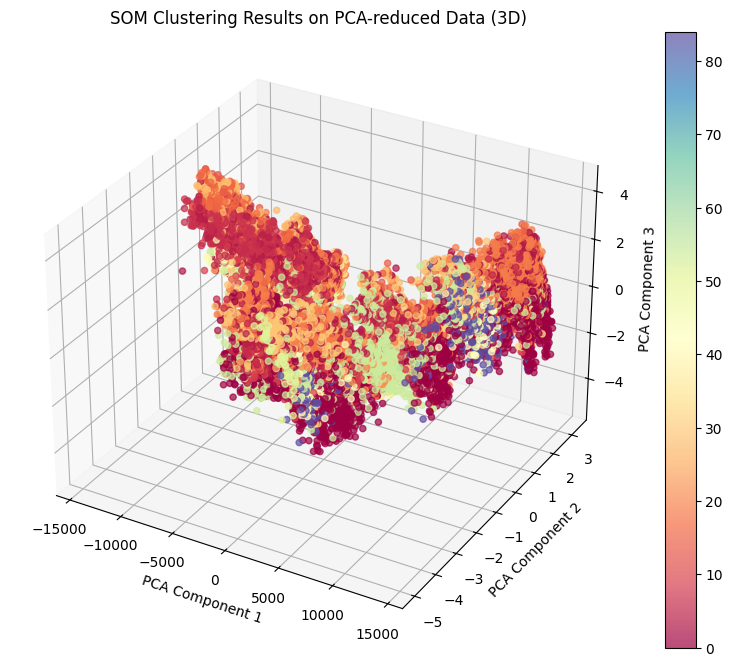

In [11]:
from minisom import MiniSom
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ==============================
# Step 1: Apply PCA for visualization
# ==============================
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df)

# ==============================
# Step 2: Normalize Data
# ==============================
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# ==============================
# Step 3: Initialize and Train SOM
# ==============================
som_grid_rows = 10
som_grid_cols = 10

som = MiniSom(x=som_grid_rows, y=som_grid_cols, input_len=df.shape[1], sigma=1.0, learning_rate=0.5)

print("Training SOM...")
som.train_random(df_scaled, num_iteration=1000)
print("SOM training complete.")

# ==============================
# Step 4: Assign clusters
# ==============================
bmu_indices = np.array([som.winner(x) for x in df_scaled])
clusters = [r * som_grid_cols + c for r, c in bmu_indices]
df['Cluster'] = clusters

# ==============================
# Step 5: Evaluate clustering
# ==============================
silhouette = silhouette_score(df_scaled, clusters)
calinski = calinski_harabasz_score(df_scaled, clusters)
davies = davies_bouldin_score(df_scaled, clusters)

print("\nClustering Metrics (SOM):")
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Calinski-Harabasz Index: {calinski:.3f}")
print(f"Davies-Bouldin Index: {davies:.3f}")

print(f"\nNumber of clusters: {len(set(clusters))}")
print("\nCluster distribution:")
print(pd.Series(clusters).value_counts().sort_index())

# ==============================
# Step 6: 3D Visualization
# ==============================
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2], 
                     c=clusters, cmap='Spectral', alpha=0.7)

ax.set_title('SOM Clustering Results on PCA-reduced Data (3D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.colorbar(scatter)
plt.show()


# Ensemble Model

In [5]:
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture
from fcmeans import FCM
from sklearn.metrics import silhouette_score, davies_bouldin_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from scipy.stats import mode
import numpy as np

# BIRCH
birch = Birch(threshold=1.0, branching_factor=25, n_clusters=3)
labels_birch = birch.fit_predict(df)

# GMM
gmm = GaussianMixture(n_components=2, covariance_type='spherical', random_state=42)
labels_gmm = gmm.fit_predict(df)

# FCM
fcm = FCM(n_clusters=2, m=1.5, max_iter=100, error=0.001, random_state=42)
fcm.fit(df.values)
labels_fcm = fcm.predict(df.values)

In [6]:
def align_labels(reference, target):
    cm = confusion_matrix(reference, target)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = dict(zip(col_ind, row_ind))
    aligned = np.array([mapping.get(label, label) for label in target])
    return aligned

labels_gmm_aligned = align_labels(labels_birch, labels_gmm)
labels_fcm_aligned = align_labels(labels_birch, labels_fcm)

In [7]:
# Stack all aligned label arrays
labels_stack = np.vstack([
    labels_birch,
    labels_gmm_aligned,
    labels_fcm_aligned
])

ensemble_labels, _ = mode(labels_stack, axis=0)
ensemble_labels = ensemble_labels.flatten()

In [14]:
sil = silhouette_score(df, ensemble_labels)
dbi = davies_bouldin_score(df, ensemble_labels)

print(f"Ensemble Silhouette Score: {sil:.3f}")
print(f"Ensemble Davies-Bouldin Index: {dbi:.3f}")

Ensemble Silhouette Score: 0.627
Ensemble Davies-Bouldin Index: 0.500


In [15]:
import pandas as pd
print("Cluster distribution:")
print(pd.Series(ensemble_labels).value_counts().sort_index())

Cluster distribution:
0    14251
2    14251
Name: count, dtype: int64


In [8]:
import plotly.express as px
from sklearn.decomposition import PCA

# Reduce dimensions to 3D using PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(df)

# Create a DataFrame for Plotly
import pandas as pd
df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
df_plot['Cluster'] = ensemble_labels

# Plot interactive 3D scatter plot
fig = px.scatter_3d(
    df_plot, x='PC1', y='PC2', z='PC3',
    color='Cluster',
    title='Interactive 3D Cluster Visualization',
    opacity=0.7
)
fig.show()

In [9]:
from sklearn.metrics import adjusted_rand_score
import numpy as np
from scipy.stats import mode

n_iterations = 50
n_samples = df.shape[0]
ari_scores = []

for _ in range(n_iterations):
    # Bootstrap sample
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    X_boot = df.iloc[indices]

    # Apply your clustering models on the bootstrap sample
    # Example for BIRCH:
    birch = Birch(threshold=1.0, branching_factor=25, n_clusters=3)
    labels_birch = birch.fit_predict(X_boot)

    # Repeat for GMM and FCM with their respective best parameters
    # Ensure to align labels as done previously

    # Perform majority voting
    labels_stack = np.vstack([labels_birch, labels_gmm_aligned, labels_fcm_aligned])
    ensemble_labels_boot, _ = mode(labels_stack, axis=0)
    ensemble_labels_boot = ensemble_labels_boot.flatten()

    # Compare with original ensemble labels
    original_labels_subset = ensemble_labels[indices]
    ari = adjusted_rand_score(original_labels_subset, ensemble_labels_boot)
    ari_scores.append(ari)

# Evaluate stability
print(f"Mean ARI: {np.mean(ari_scores):.3f}")
print(f"Standard Deviation of ARI: {np.std(ari_scores):.3f}")

Mean ARI: -0.000
Standard Deviation of ARI: 0.000
